In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu==2.8.1

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [8]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=213
data_train=pd.read_csv('/content/BTC-USD.csv')
df=pd.DataFrame(data_train)

In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,21/08/2022,21160.39258,21668.84570,21103.19727,21534.12109,21534.12109,2.310231e+10
1,22/08/2022,21531.46289,21531.46289,20939.18359,21398.90820,21398.90820,3.166650e+10
2,23/08/2022,21401.04492,21646.20313,20955.13867,21528.08789,21528.08789,3.187828e+10
3,24/08/2022,21526.45508,21783.07617,21195.00586,21395.01953,21395.01953,3.196225e+10
4,25/08/2022,21395.45898,21789.63672,21362.44141,21600.90430,21600.90430,3.102868e+10


In [14]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,17/08/2023,28699.80273,28745.94727,25409.11133,26664.55078,26664.55078,3.112085e+10
362,18/08/2023,26636.07813,26808.19531,25668.92188,26049.55664,26049.55664,2.402624e+10
363,19/08/2023,NaN,NaN,NaN,NaN,NaN,NaN
364,20/08/2023,NaN,NaN,NaN,NaN,NaN,NaN
365,21/08/2023,26189.17578,26189.17578,26043.20898,26091.59570,26091.59570,9.214676e+09


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,364.000000,364.000000,364.000000,364.000000,364.000000,3.640000e+02
mean,23539.268298,23911.267374,23180.014659,23553.250467,23553.250467,2.356698e+10
std,4786.420598,4857.871987,4731.072519,4787.787967,4787.787967,1.341323e+10
min,15782.300780,16253.047850,15599.046880,15787.284180,15787.284180,6.194358e+09
25%,19404.933592,19644.859372,19112.300780,19405.889160,19405.889160,1.437635e+10
50%,23123.395510,23518.148440,22803.664065,23143.318360,23143.318360,2.035741e+10
75%,28078.487795,28521.150387,27474.754398,28087.126950,28087.126950,3.013759e+10
max,31474.720700,31814.515630,30659.355470,31476.048830,31476.048830,1.189920e+11


In [12]:
df.shape

(366, 7)

Text(0, 0.5, 'Close Price (USD)')

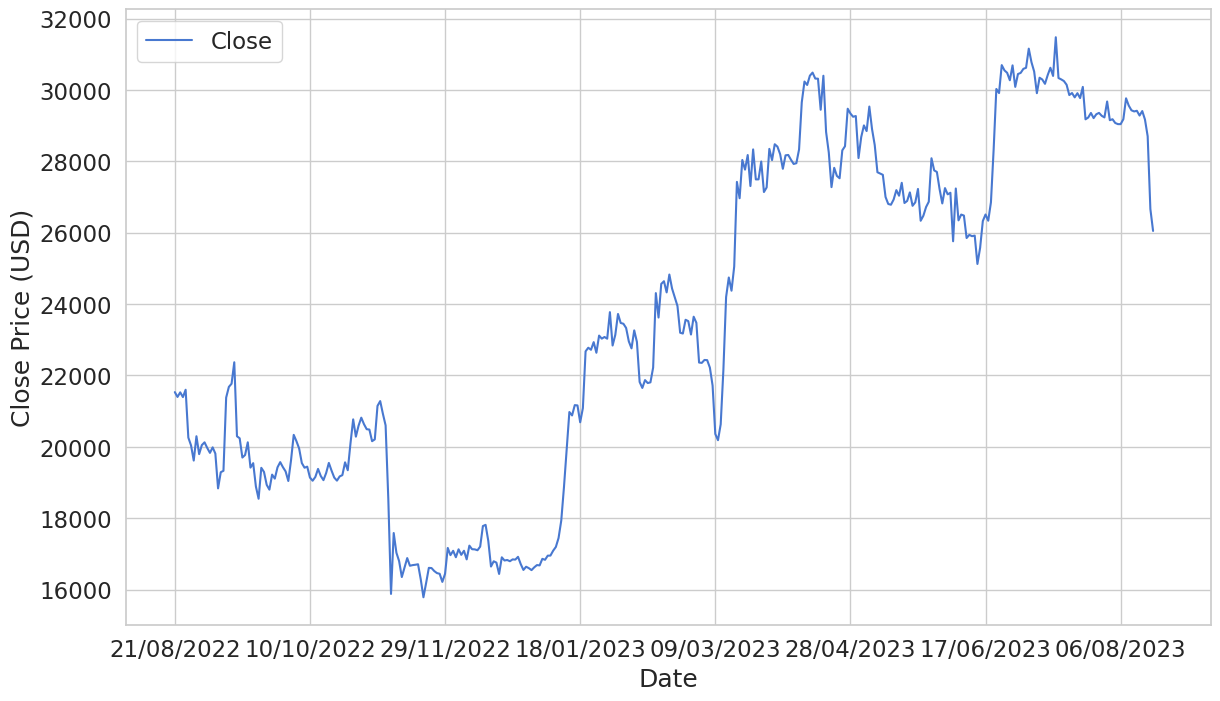

In [11]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [15]:
##Normalizations
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [16]:
scaled_close.shape

(366, 1)

In [17]:
np.isnan(scaled_close).any()

True

In [18]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [19]:
scaled_close = scaled_close.reshape(-1, 1)

In [20]:
np.isnan(scaled_close).any()

False

In [21]:
##Preprocessing
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [22]:
X_train.shape

(250, 99, 1)

In [23]:
X_test.shape

(14, 99, 1)

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout

WINDOW_SIZE = 99  # Example window size
DROPOUT = 0.2  # Example dropout rate

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
# Add more layers as needed


model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

model.summary()  # Print model summary


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 99, 198)          79992     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 99, 198)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 99, 396)          628848    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 198)              392832    
 nal)                                                            
                                                      

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Train the model on the training data
history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1,validation_split = 0.1)

Epoch 1/30
4/4 [==============================] - 10s 3s/step - loss: 0.0028 - val_loss: 7.4794e-04
Epoch 2/30
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0015
Epoch 3/30
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 6.0550e-04
Epoch 4/30
4/4 [==============================] - 9s 2s/step - loss: 0.0027 - val_loss: 0.0036
Epoch 5/30
4/4 [==============================] - 8s 2s/step - loss: 0.0026 - val_loss: 5.0493e-04
Epoch 6/30
4/4 [==============================] - 9s 2s/step - loss: 0.0024 - val_loss: 0.0031
Epoch 7/30
4/4 [==============================] - 10s 2s/step - loss: 0.0023 - val_loss: 7.1578e-04
Epoch 8/30
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/30
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0021
Epoch 10/30
4/4 [==============================] - 9s 2s/step - loss: 0.0028 - val_loss: 5.4194e-04
Epoch 11/30
4/4 [==========

In [34]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 358ms/step - loss: 0.0052


0.005215990822762251

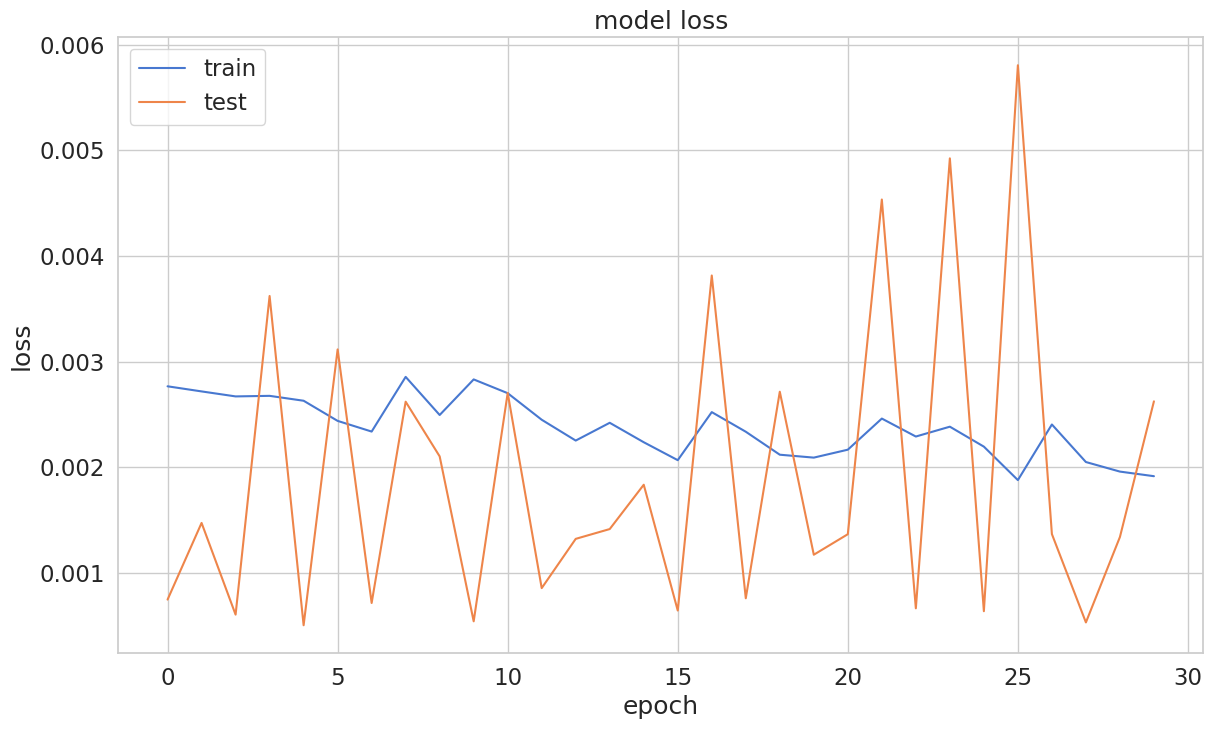

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##model prediction

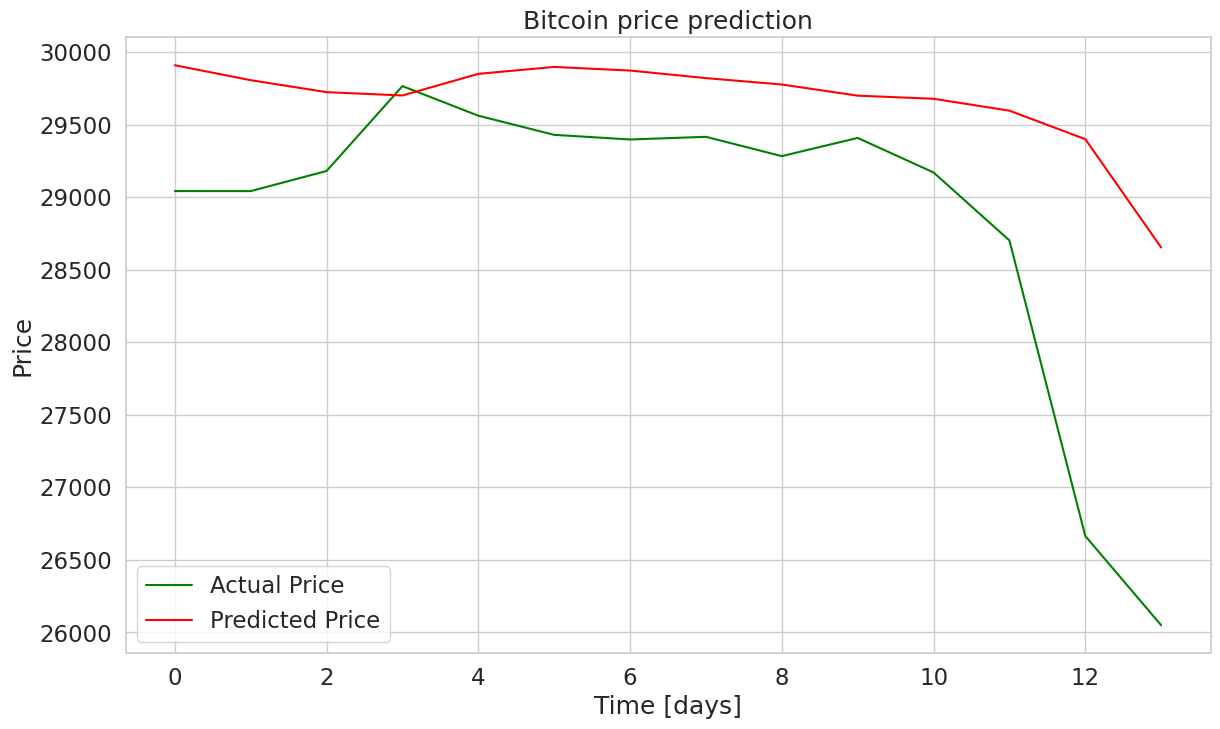

In [36]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();